# Inference using a trained TauVAE

In [136]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from skimage.io import imread
from skimage.util import montage

import enum
from dataclasses import dataclass

In [3]:
from cellxpredict.config import FullConfig
from cellxpredict.models import _build_full
from cellxpredict.prepare import normalize_glimpse

In [4]:
from cellx.tools.saliency import visualize_saliency

In [5]:
config = FullConfig(
    model_dir = Path("/media/quantumjot/DataIII/Models/docker"),
    use_probabilistic_encoder=True,
)

In [6]:
config

FullConfig(model='full', src_dir=None, model_dir=PosixPath('/media/quantumjot/DataIII/Models/docker'), log_dir=None, latent_dims=32, intermediate_dims=256, capacity=50, gamma=1000, input_shape=(64, 64, 2), layers=[8, 16, 32, 64], num_outputs=3, max_len=128, dropout_rate=0.0, noise=1.0, use_probabilistic_encoder=True)

In [7]:
model = _build_full(config)

/home/quantumjot/anaconda3/envs/tf2/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [8]:
model.summary()

Model: "TauVAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 64, 64, 2)]  0         
                                                                 
 tf.reshape (TFOpLambda)     (None, 64, 64, 2)         0         
                                                                 
 variational_encoder (Functi  [(None, 32),             2138928   
 onal)                        (None, 32),                        
                              (None, 32)]                        
                                                                 
 tf.reshape_1 (TFOpLambda)   (None, 128, 32)           0         
                                                                 
 pca_transform (PCATransform  (None, 128, 32)          0         
 )                                                               
                                                            

In [137]:
class CellFate(enum.Enum):
    APOPTOSIS = 0 
    MITOSIS = 1 
    SYNTHETIC = 2


@dataclass 
class Example:
    glimpse: np.ndarray 
    label: CellFate 
    filename: Path
    cutoff: int

In [157]:
def load_example(pth: Path, filename: Path):
    label = "apoptosis" if "apop" in str(filename) else "mitosis"
    
    meta_fn = pth / "metadata" / label / filename.with_suffix(".npz")
    img_fn = pth / "data" / label / filename.with_suffix(".tif")
    
    img =  imread(str(img_fn)) # weird output if not using string
    meta = np.load(meta_fn)
    cutoff = meta["cutoff"]

    # prepare the data 
    img = np.moveaxis(img, 1, -1)
    img = img[:cutoff, ...]
    img = img[-128:, ...]
    img = normalize_glimpse(img.astype(np.float32))
    img = img[np.newaxis, ...]
    
    example = Example(
        glimpse=img,
        label=CellFate[label.upper()],
        filename=img_fn,
        cutoff=cutoff,
    )
    
    return example

In [158]:
example = load_example(
    Path("/media/quantumjot/DataIII/Data/VAE_new/training/glimpses/"),
    Path("GV0800_Pos4_352_RFP_apop"),
)

354


In [146]:
logits = model.predict(example.glimpse)

In [163]:
print(f"Predicted label: \t{CellFate(np.argmax(logits)).name} \nReal label: \t\t{example.label.name}")

Predicted label: 	APOPTOSIS 
Real label: 		APOPTOSIS


In [147]:
gradients, _ = visualize_saliency(
    model,
    example.glimpse,
    n_samples=50,
)

In [148]:
def rgb_montage(x, rescale_intensity: bool = True):
    m = []
    for dim in range(x.shape[-1]):
        mc = montage(x[0, ..., dim], grid_shape=(4, 32), rescale_intensity=rescale_intensity)
        m.append(mc)
        
    rgb = np.stack(
        [m[1], m[0], m[1]], axis=-1
    )

    return rgb

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


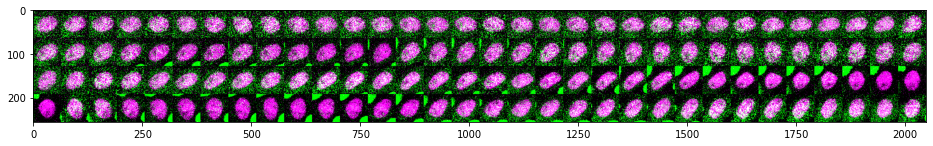

In [150]:
plt.figure(figsize=(16, 5))
plt.imshow(rgb_montage(example.glimpse, rescale_intensity=False))